2022.12 wz

Determine dislocation dissociation distance from TEM images, images located in `demo` folder are taken by [prof. Chen](https://kdb.iimc.kyoto-u.ac.jp/profile/en.4606c31af9b59cf0.html) (from J. Alloys Compd.,**959**, 170555 (2023))

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from itertools import product
import scipy
from scipy.optimize import curve_fit
from statsmodels.regression.linear_model import OLS
import math
import os

from tsmoothie.smoother import *

from datetime import datetime
import pandas as pd

Step 0: store info of Burgers vector from diffraction pattern.

[[[678.5 569.5  33.8]
  [919.5 998.5   7.8]]]


2024-11-08 00:54:00.567 python[20138:31762003] +[IMKClient subclass]: chose IMKClient_Legacy
2024-11-08 00:54:00.567 python[20138:31762003] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


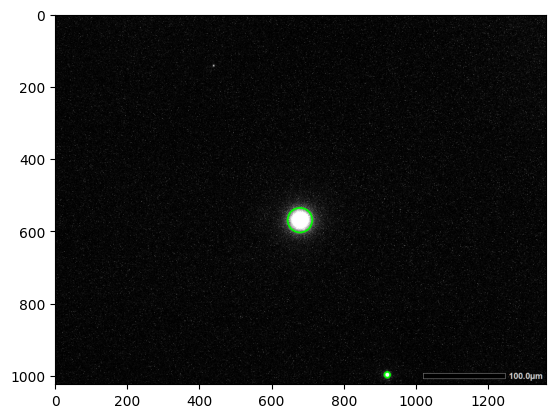

In [6]:
pth_saed = r'./demo/b_vec.bmp'
image = cv2.imread(pth_saed)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 5)
centre = []

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 0.3, 80,
                            param1=110, param2=20, minRadius=0, maxRadius=50)
print(circles)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)
        centre.append([x, y])

cv2.imshow("Detected Circles", image)
cv2.waitKey(0)

cv2.destroyAllWindows()

plt.imshow(image)

Step 1: load the image. Do limited processing: e.g. contrast enhancement.

#### Click the anchor points for initializing the dislocation line detection.

- Left-click to draw points.
- Right-click to redraw the previous one.
- Mid-click to generate interpolated curve.

[[242 428]]
Burgers vector info saved.
done at 2024-11-08 01:07


True

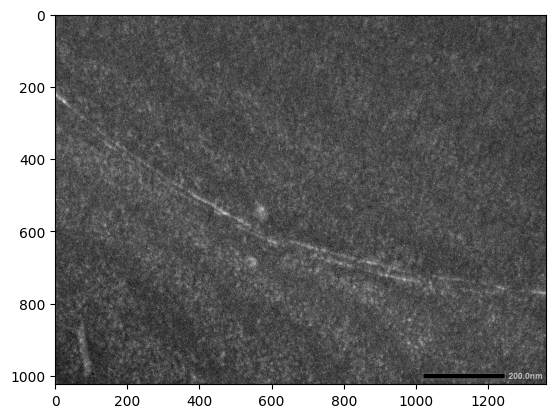

In [51]:
pth_wb_ = f'./demo/wb_disso_Chen.bmp'
pth_wb = f'./demo/wb_disso_Chen_sav.bmp'
pth_out = f'./demo/'

#TODO save burgers vector
b = np.diff(np.array(centre), axis=0)
print(b)
np.save(os.path.join(pth_out, 'b_info.npy'), b)
print('Burgers vector info saved.')
print('done at', datetime.now().strftime("%Y-%m-%d %H:%M"))

image = cv2.imread(pth_wb_)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#* Gamma
a = 1
gamma = 1.2
image = a*np.power(image, gamma)
image = (image-np.min(image))/(np.max(image)-np.min(image))*255
image = image.astype('uint8')

#* Resize 
# image = cv2.resize(image, (0,0), fx=0.5, fy=0.5)

#TODO Rotate for pi/2 for burgers vector
# image = np.rot90(image, 3)
plt.imshow(image, cmap='gray')

cv2.imwrite(pth_wb, image)

In [ ]:
#TODO gauge part (if necessary)
# pth_wb = pth_out + 'scalebar.png'

image_anchor = cv2.imread(pth_wb)
image_anchor = cv2.cvtColor(image_anchor, cv2.COLOR_BGR2GRAY)
#! Rotate for pi/2 if necessary
image_rotate = False
if image_rotate:
    image_anchor = np.rot90(image_anchor, 1)
#* Remove the high-frequency noise.
image_anchor = cv2.GaussianBlur(image_anchor, (3, 3), 0)
image_raw = image_anchor.copy()
# Globally defined variable
points = []
p_inter_, p_inter_pixel = [], []
p_size = 3
drawing = []

def ex_coord(x, y, b_length):
    return [[x+i,y+j] for i, j in product(np.arange(-b_length, b_length+1), repeat = 2)]

# Set up the mouse callback function
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        #* Prepare to drag the point
        drawing.append(1)

        #* Draw black points on the surronding pixels [x+-2, y+-2]
        # cv2.circle(image, (x, y), radius=5, color=0, thickness=3)
        mark_coord = ex_coord(x, y, p_size)
        for item in mark_coord:
            image_anchor[item[1], item[0]] = 0

        cv2.imshow("image", image_anchor)
        points.append([x, y])
        print(f"Left button clicked at ({x}, {y})")

    elif event == cv2.EVENT_MOUSEMOVE:
        if len(drawing) >= 1:
            if len(points) >= 2:
                raw_norm = np.linalg.norm(np.array(points)-np.array([x, y]), axis=1)
            elif len(points) == 1:
                raw_norm = np.linalg.norm(np.array(points)-np.array([x, y]))
            else:
                raise ValueError("Nothing to move.")

            if np.min(raw_norm) < 30:
                #* Delete the origin
                move_index = np.argmin(raw_norm)
                x_, y_ = points[move_index]
                mark_coord_raw = ex_coord(x_, y_, p_size)
                for item_ in mark_coord_raw:
                    image_anchor[item_[1], item_[0]] = image_raw[item_[1], item_[0]]

                # cv2.circle(image, (x_, y_), radius=5, color=255, thickness=3)
                cv2.imshow("image", image_anchor)
                points.pop(move_index)     

    elif event == cv2.EVENT_LBUTTONUP:
        drawing.clear()

        #* Add the new
        mark_coord = ex_coord(x, y, p_size)
        for item in mark_coord:
            image_anchor[item[1], item[0]] = 0 

        cv2.imshow("image", image_anchor)    
        points.append([x, y])
        print(f"Left button moves the point to ({x}, {y})")     

    elif event == cv2.EVENT_RBUTTONDOWN:
        # Remove the point at the location where the mouse is right-clicked
        if len(points) >= 2:
            raw_norm = np.linalg.norm(np.array(points)-np.array([x, y]), axis=1)
        elif len(points) == 1:
            raw_norm = np.linalg.norm(np.array(points)-np.array([x, y]))
        else:
            raise ValueError("Nothing to remove.")

        del_index = np.argmin(raw_norm)

        #* Remove marked points.
        x_, y_ = points[del_index]
        mark_coord_raw = ex_coord(x_, y_, p_size)
        for item_ in mark_coord_raw:
            image_anchor[item_[1], item_[0]] = image_raw[item_[1], item_[0]]

        # cv2.circle(image, (x_, y_), radius=5, color=255, thickness=3)
        cv2.imshow("image", image_anchor)
        points.pop(del_index)

    elif event == cv2.EVENT_MBUTTONDOWN and len(points) > 2:
        
        try:
            for item, pix in zip(p_inter_, p_inter_pixel):
                image_anchor[item[1], item[0]] = pix
            p_inter_.clear()
            p_inter_pixel.clear()
        except:
            pass

        points_ = np.unique(points.copy(), axis=0)
        p_x = np.linspace(np.min(np.array(points_)[:,0]), np.max(np.array(points_)[:,0]), 1000)
        #* Sort and remove duplicate along x-axis.
        p_f = interpolate.interp1d(
            np.array(points_)[:,0], np.array(points_)[:,1], kind='quadratic')
        p_y = p_f(p_x)

        p_inter = np.concatenate([p_x.reshape(-1,1), p_y.reshape(-1,1)], axis=1)
        # print(p_inter)
        p_inter = p_inter.astype(np.int32)
        for item in p_inter:
            p_inter_pixel.append(image_raw[item[1], item[0]])
            p_inter_.append(item)

        #* Draw the interpolated line.
        for item in p_inter:
            # print(item)
            image_anchor[item[1], item[0]] = 0
            # cv2.drawMarker(image, (item[0], item[1]),0, markerType=cv2.MARKER_STAR, 
            # markerSize=2, thickness=1, line_type=cv2.LINE_AA)

        cv2.imshow("image", image_anchor)

cv2.namedWindow("image")
cv2.setMouseCallback("image", mouse_callback)

cv2.imshow("image", image_anchor)
cv2.waitKey(0)

cv2.destroyAllWindows()

Left button clicked at (111, 336)
Left button moves the point to (111, 336)
Left button clicked at (136, 358)
Left button moves the point to (136, 358)
Left button clicked at (159, 372)
Left button moves the point to (159, 372)
Left button clicked at (186, 391)
Left button moves the point to (186, 391)
Left button clicked at (213, 412)
Left button moves the point to (213, 412)
Left button clicked at (289, 461)
Left button moves the point to (289, 461)
Left button clicked at (322, 486)
Left button moves the point to (322, 486)
Left button clicked at (350, 501)
Left button moves the point to (350, 501)
Left button clicked at (378, 515)
Left button moves the point to (378, 515)
Left button clicked at (400, 529)
Left button moves the point to (400, 529)
Left button clicked at (446, 551)
Left button moves the point to (446, 551)
Left button clicked at (507, 589)
Left button moves the point to (507, 589)
Left button clicked at (529, 597)
Left button moves the point to (529, 597)
Left button 

Save gauge info derived in step 1 cellblock.

In [30]:
points = np.unique(points, axis=0)
pth_out = pth_out
np.save(os.path.join(pth_out, 'gauge_info.npy'), points)
print('Gauge info saved.')
print('done at', datetime.now().strftime("%Y-%m-%d %H:%M"))

Gauge info saved.
done at 2024-11-08 01:02


Save points info derived in step 1 cellblock.

In [33]:
points = np.unique(points, axis=0)
pth_out = pth_out
np.save(os.path.join(pth_out, 'raw_points.npy'), points)
print(points)
print('done at', datetime.now().strftime("%Y-%m-%d %H:%M"))

[[111 336]
 [136 358]
 [159 372]
 [186 391]
 [213 412]
 [289 461]
 [322 486]
 [350 501]
 [378 515]
 [400 529]
 [446 551]
 [507 589]
 [529 597]
 [558 613]
 [580 624]
 [610 636]]
done at 2024-11-08 01:03


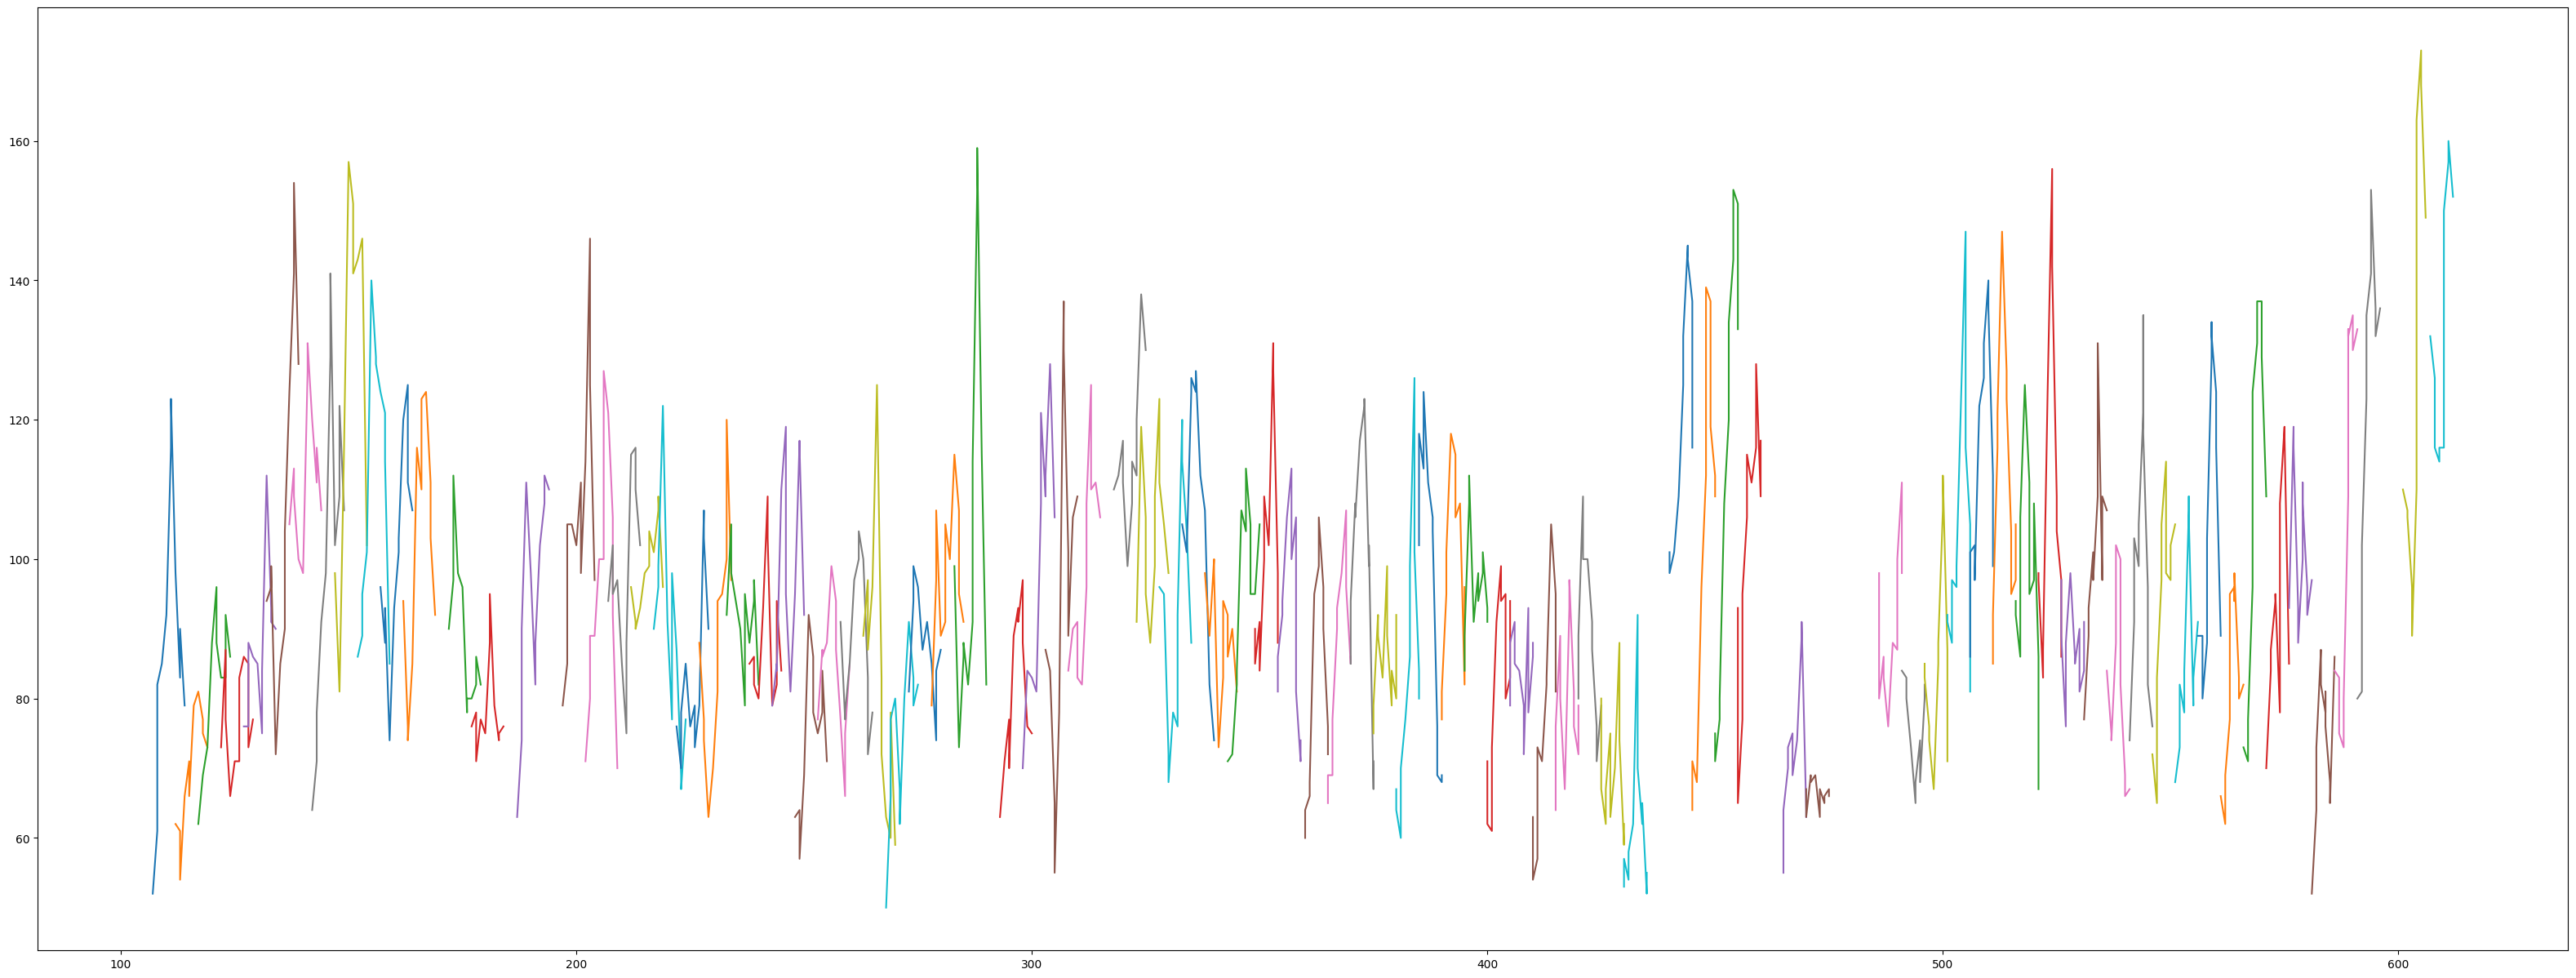

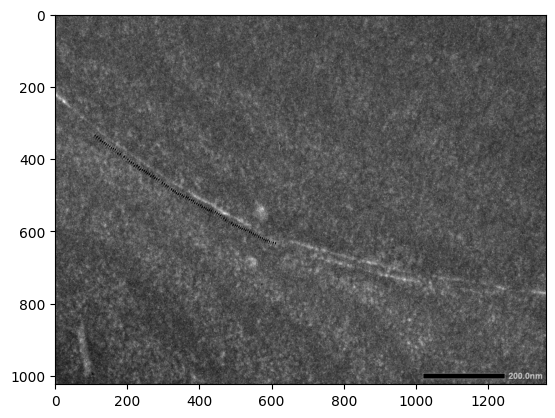

In [ ]:
def perpendic_line(p1, p2, p_test):
    x1, y1 = p1
    x2, y2 = p2
    y_mid, x_mid = p_test #* Based on the interpolated points
    # x_mid, y_mid = (x1+x2)/2, (y1+y2)/2
    #* x the horizontal term
    k_vec = (x1-x2)/(y1-y2)
    k_vec_ = -1/k_vec
    y_inter = y_mid - k_vec_*(x_mid)

    return k_vec_, y_inter

def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

pth_load = pth_out
points = np.load(os.path.join(pth_load, 'raw_points.npy')) #* Load the points

image = cv2.imread(pth_wb)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#! Rotate for pi/2 if necessary
if image_rotate:
    image = np.rot90(image, 1)
#* Remove the high-frequency noise.
image = cv2.GaussianBlur(image, (3, 3), 0)

points = np.array(points)
#* Generate the interpolated line.
points_ = points.copy()
len_pin = 100 #TODO length of interpolated lines
p_x = np.linspace(np.min(np.array(points_)[:,0]), np.max(np.array(points_)[:,0]), len_pin)
p_f = interpolate.interp1d(
    np.array(points_)[:,0], np.array(points_)[:,1], kind='quadratic')
p_y = p_f(p_x)
p_inter = np.concatenate([p_x.reshape(-1,1), p_y.reshape(-1,1)], axis=1)

#* Sort the points by y-coordinate
sorted_array = points[points[:, 1].argsort()]
chosen_intensity_list, chosen_intensity_coord = [], []
intensity_list_all, item_list_all = [], []
range_perpendicular = 5 #TODO Length of interpolated line (pins that perpendicular to the line).
intensity_threshold = 20 #TODO maximun tolerant variance, to remove the noise
mark_point_size = 1
fig, ax = plt.subplots(figsize=(40,15))
len_interline = len(p_inter)

#* Go through the interpolated line between p1 and p2
for p_ind in range(len_interline):

    p1, p2 = p_inter[np.clip(p_ind-10, 0, len_interline-1)], p_inter[np.clip(p_ind+10, 0, len_interline-1)]
    p_mid = p_inter[p_ind].astype(np.int32)
    k_, b_ = perpendic_line(p1, p2, p_mid)
    #* Display the interpolated line
    image[p_mid[1], p_mid[0]] = 0
    
    intensity_list = []
    # p_mid = (p1+p2)/2
    #* Generate the perpendicular vector
    x_test = np.linspace(
        p_mid[1]-range_perpendicular, p_mid[1]+range_perpendicular, range_perpendicular*2+1)
    y_test = k_*x_test + b_
    x_test, y_test = x_test.astype(np.int32), y_test.astype(np.int32)
    perpendicular_line = np.concatenate([x_test.reshape(-1,1), y_test.reshape(-1,1)], axis=1)
    #* y_test as the vertical term, x_test as the horizontal term

    # print(single_p, perpendicular_line)

    for item in perpendicular_line:
        # print(item)
        image[item[0], item[1]] = 0
        #* Through the horizontal axis: item[1]; vertical: item[0]
        intensity_list.append([item[1], image_raw[item[0], item[1]]])

    intensity_list = np.array(intensity_list)

    #* From now on let's use Gaussian dist. fitting result to determine 
    #* The chosen coordinates.add()
    x_raw = np.arange(1, range_perpendicular*2+2)
    y_raw = intensity_list[:,1]-np.min(intensity_list[:,1])
    y_raw = y_raw/np.sum(y_raw)
    #* Denoise the raw data.
    w_size = 9 #TODO increase the window size
    kernel = np.ones(w_size) / w_size
    y_raw_smooth = np.convolve(y_raw, kernel, mode='same')

    popt, pcov = curve_fit(gaussian, x_raw, y_raw_smooth)
    mu, sigma = popt

    model = OLS(y_raw_smooth, gaussian(x_raw, *popt))
    results = model.fit()
    mse = np.var(y_raw_smooth - results.predict(x_raw))

    #* First step: simply take the maximum of intensity list as the 
    #* effective signal.
    ind_max = np.argmax(intensity_list[:,1])
    ind_max = int(mu)
    chosen_intensity = np.max(intensity_list[:,1])-np.min(intensity_list[:,1])

    #* remove the pin with out peak
    int_raw = intensity_list[:,1]
    if np.argmax(int_raw) == 0 or np.argmax(int_raw) == len(int_raw)-1:
        continue
    
    plt.plot(intensity_list[:,0], intensity_list[:,1])
    
    # chosen_intensity_coord.append(perpendicular_line[ind_max])
    # chosen_intensity_list.append(chosen_intensity)
    # intensity_list_all.append(intensity_list[:,1]) #* The intensity for all
    # item_list_all.append(intensity_list[:,0]) #* The coordinates for all

    #* If chosen intensity is greater than the threshold, it will
    #* be marked on the image.
    if mse < intensity_threshold:
        
        chosen_intensity_coord.append(perpendicular_line[ind_max])
        chosen_intensity_list.append(chosen_intensity)
        intensity_list_all.append(intensity_list[:,1]) #* The intensity for all
        item_list_all.append(intensity_list[:,0]) #* The coordinates for all
        
        #* Return the index corresponding to the +-0.3 z of fitted GS dist. 
        z_indlist = np.arange(int(mu - 0.3*sigma), int(mu + 0.3*sigma)+1)
        z_indlist = np.unique(np.clip(z_indlist, 0, len(intensity_list)-1))
        for ind in z_indlist:
            mark_coord = ex_coord(
                perpendicular_line[ind][0], perpendicular_line[ind][1], mark_point_size)
            for item in mark_coord:
                image[item[0], item[1]] = 0

intensity_list_all = np.array(intensity_list_all)
item_list_all = np.array(item_list_all)
plt.show()

cv2.imshow("image", image)
cv2.waitKey(0)

cv2.destroyAllWindows()

plt.imshow(image, cmap='gray')

In [35]:
pth_out = pth_out
cv2.imwrite(pth_out+'/runs_lower.png', image)
print('lower image saved')
print('done at', datetime.now().strftime("%Y-%m-%d %H:%M"))

lower image saved
done at 2024-11-08 01:03


In [22]:
pth_out = pth_out
cv2.imwrite(pth_out+'/runs_upper.png', image)
print('upper image saved')
print('done at', datetime.now().strftime("%Y-%m-%d %H:%M"))

upper image saved
done at 2024-11-08 01:01


Determine threshold from distribution below to extract the effective signal. AIC/BIC/variance can be used. Default variance.

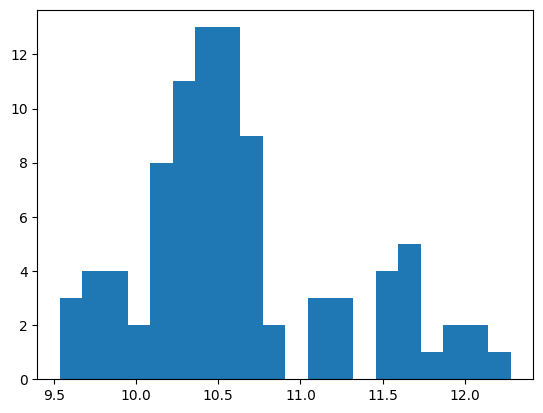

In [36]:
from scipy.optimize import curve_fit
from statsmodels.tools.numdiff import approx_fprime
from statsmodels.regression.linear_model import OLS
import numpy as np

def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

def poisson(k, lamda):
    return (lamda**k * np.exp(-lamda)) / scipy.special.factorial(k)

def binomial(k, n, p):
    return (scipy.special.factorial(n) / (scipy.special.factorial(k) * scipy.special.factorial(n-k))) * p**k * (1-p)**(n-k)

def gamma(x, alpha, beta):
    return (1 / (beta**alpha * scipy.special.gamma(alpha))) * x**(alpha-1) * np.exp(-x/beta)

stats_list = []
single_test = False #! Demo or Application

for i in range(len(intensity_list_all)):
# for i in range(3,4):
    x_raw = np.arange(1,range_perpendicular*2+2)
    y_raw = intensity_list_all[i]-np.min(intensity_list_all[i])
    y_raw = y_raw/np.sum(y_raw)
    # p = anderson(y_raw, dist='norm')
    #* Denoise the raw data.
    w_size = 5
    kernel = np.ones(w_size) / w_size
    y_raw_smooth = np.convolve(y_raw, kernel, mode='same')

    popt, pcov = curve_fit(gaussian, x_raw, y_raw_smooth)

    model = OLS(y_raw_smooth, gaussian(x_raw, *popt))
    results = model.fit()
    aic = results.aic
    
    bic = results.bic
    
    mse = np.var(y_raw_smooth - results.predict(x_raw))
    
    stats_list.append([aic, bic, mse])

    x_fitted = np.linspace(1,range_perpendicular*2+2,50)
    y_fitted = gaussian(x_fitted, *popt)

    if single_test:
        plt.plot(x_raw, y_raw)
        plt.plot(x_raw, y_raw_smooth)
        plt.plot(x_fitted, y_fitted)

        plt.title(f'AIC: {round(aic,1)}, BIC: {round(bic,1)}, Var: {round(mse,1)}')
        print('AIC: %.3f' % aic)
        print('BIC: %.3f' % bic)
        print('MSE: %.3f' % mse)

if not single_test:
    plt.hist(np.array(stats_list)[:,2], bins=20)
    # plt.hist(np.array(stats_list)[:,1], bins=20)

LOWESS smoothing on dislocation line represented by valid points.

<function matplotlib.pyplot.show(close=None, block=None)>

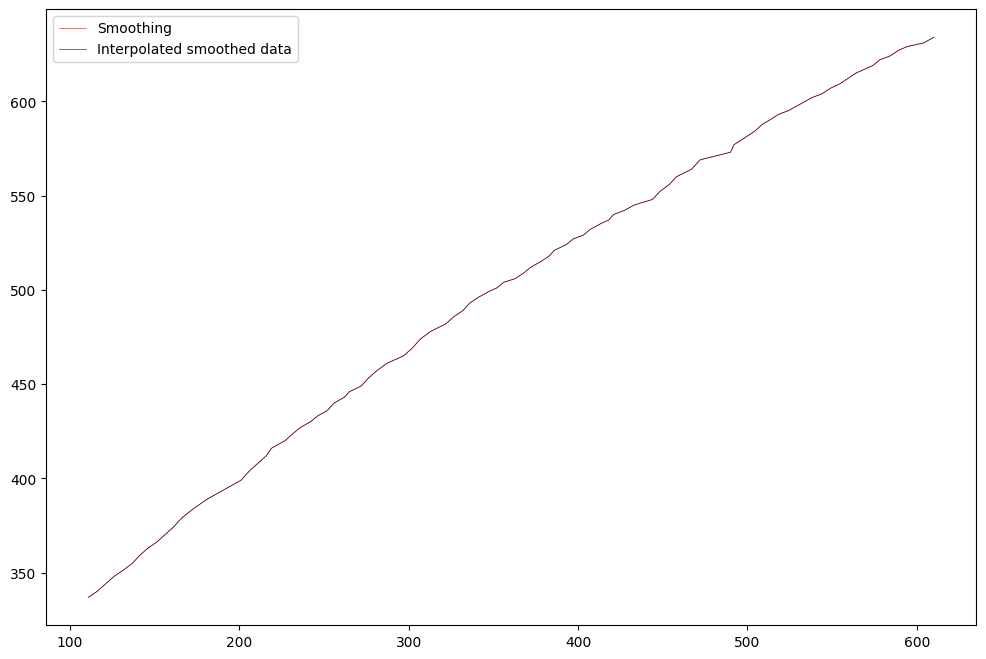

In [ ]:
chosen_intensity_coord = np.array(chosen_intensity_coord)

x_coord = chosen_intensity_coord[:,1]
x_coord_, ind = np.unique(x_coord, return_index=True)
chosen_intensity_coord = chosen_intensity_coord[ind]

data = chosen_intensity_coord[:,0]
#TODO smoothing parameters
smoother = LowessSmoother(smooth_fraction=0.15, iterations=6)
smoother.smooth(data)

# generate intervals
low, up = smoother.get_intervals('prediction_interval', confidence=0.05)
bound = np.concatenate([low.T, up.T], axis=1)
effect_ind = np.array([i for i in range(len(bound)) if data[i] > bound[i][0] and data[i] < bound[i][1]])
abnormal_ind = np.setdiff1d(np.arange(len(bound)), effect_ind)

fig, ax = plt.subplots(figsize=(12,8))

smoothed_data = smoother.smooth_data[0]

#* Interpolate the smoothed data
p_x = np.linspace(np.min(x_coord), np.max(x_coord), 5000)

p_f = interpolate.interp1d(
    x_coord_, smoothed_data, kind='slinear')
p_y = p_f(p_x)

plt.plot(x_coord_, smoothed_data, label='Smoothing', color='r', alpha=0.8, linewidth=0.5)
# plt.fill_between(x_coord, low[0], up[0], alpha=0.3, color='r', label='68%')
plt.plot(p_x, p_y, label='Interpolated smoothed data', color='k', alpha=0.8, linewidth=0.5)

plt.legend()
plt.show

Store the obtained data points

In [26]:
disloc_info = {'upper':{}, 'lower':{}}
print('done at', datetime.now().strftime("%Y-%m-%d %H:%M"))

done at 2024-11-08 01:02


In [27]:
disloc_info['upper']['chosen_intensity_coord'] = chosen_intensity_coord
disloc_info['upper']['effect_ind'] = effect_ind
disloc_info['upper']['abnormal_ind'] = abnormal_ind
disloc_info['upper']['bound'] = bound 
disloc_info['upper']['smoothed_data'] = smoothed_data
print('info of UPPER dislocation been saved.')
print('done at', datetime.now().strftime("%Y-%m-%d %H:%M"))

info of UPPER dislocation been saved.
done at 2024-11-08 01:02


In [39]:
disloc_info['lower']['chosen_intensity_coord'] = chosen_intensity_coord
disloc_info['lower']['effect_ind'] = effect_ind
disloc_info['lower']['abnormal_ind'] = abnormal_ind
disloc_info['lower']['bound'] = bound 
disloc_info['lower']['smoothed_data'] = smoothed_data
print('info of LOWER dislocation been saved.')
print('done at', datetime.now().strftime("%Y-%m-%d %H:%M"))

info of LOWER dislocation been saved.
done at 2024-11-08 01:04


In [ ]:
pth_load = pth_out
points = np.load(os.path.join(pth_load, 'gauge_info.npy'))
#TODO define gauge - pix relationship
disloc_info['gauge'] = [points, 200] #* Store the mesurement (pix) and the real value (nm)
print('info of GAUGE been saved.')
print('done at', datetime.now().strftime("%Y-%m-%d %H:%M"))

info of GAUGE been saved.
done at 2024-11-08 01:04


In [52]:
pth_load = pth_out
b_vec = np.load(os.path.join(pth_load, 'b_info.npy'))
disloc_info['b'] = b_vec
print('info of burgers vector been saved. b=', b_vec)
print('done at', datetime.now().strftime("%Y-%m-%d %H:%M"))

info of burgers vector been saved. b= [[242 428]]
done at 2024-11-08 01:07


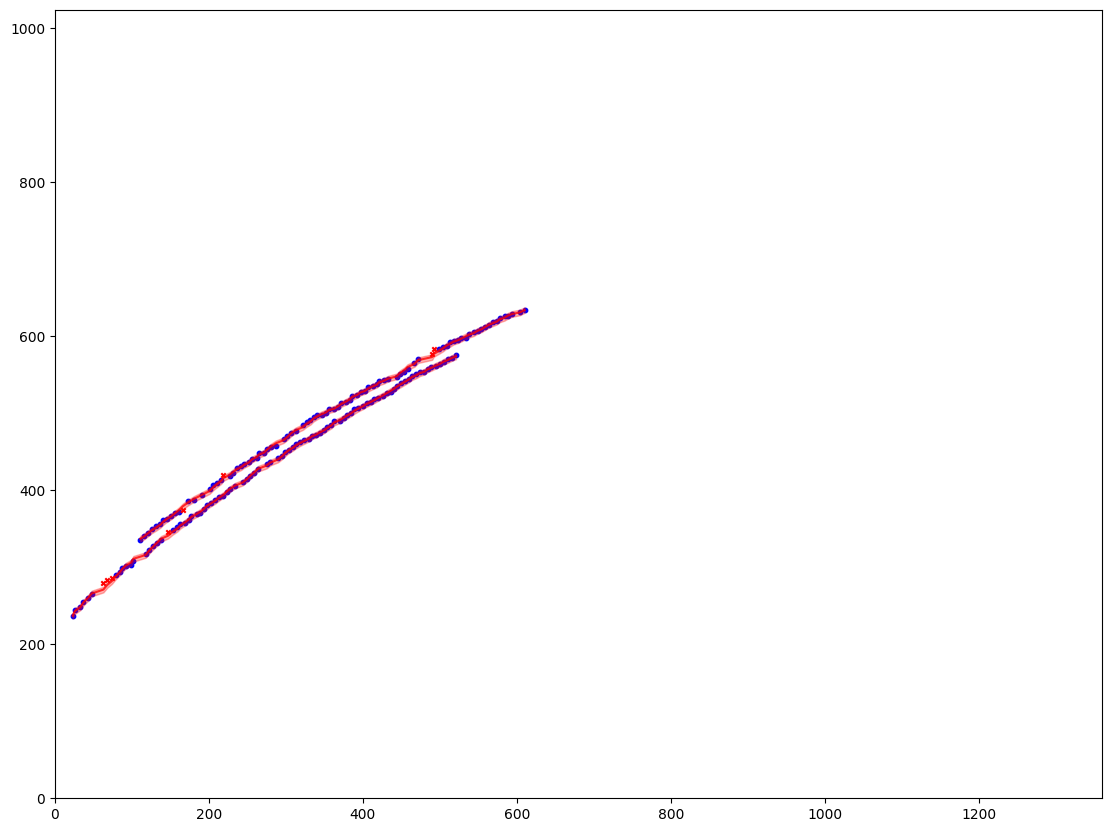

In [45]:
def draw_dislocplot():
    # fig, ax = plt.subplots(figsize=(20,15))

    for label_ in ['upper', 'lower']:
        chosen_intensity_coord = np.array(disloc_info[label_]['chosen_intensity_coord']).copy()
        smoothed_data = disloc_info[label_]['smoothed_data'].copy()
        effect_ind = disloc_info[label_]['effect_ind'].copy()
        abnormal_ind = disloc_info[label_]['abnormal_ind'].copy()
        bound = disloc_info[label_]['bound'].copy()
        low, up = bound[:,0], bound[:,1]

        x_coord = chosen_intensity_coord[:,1]

        #* Interpolate the smoothed data
        p_x = np.linspace(np.min(np.array(x_coord)), np.max(np.array((x_coord))), 5000)
        p_f = interpolate.interp1d(
            x_coord, smoothed_data, kind='linear')
        p_y = p_f(p_x)
        
        plt.scatter(x_coord[effect_ind], chosen_intensity_coord[effect_ind,0], s=10,
                    c='b', marker='o', label='effect')
        plt.scatter(x_coord[abnormal_ind], chosen_intensity_coord[abnormal_ind,0], s=10, c='r',
                    marker='x', label='abnormal')
        plt.plot(x_coord, smoothed_data, label='Smoothing', color='r', alpha=0.8)
        plt.fill_between(x_coord, low, up, alpha=0.3, color='r', label='68%')

    # plt.legend()
    # plt.show()

fig, ax = plt.subplots(figsize=(image.shape[1]/100, image.shape[0]/100))
plt.xlim(0, image.shape[1]) 
plt.ylim(0, image.shape[0])

plt.gca().set_aspect('equal', adjustable='box')
draw_dislocplot()
plt.show()

Pixel per nm

In [43]:
points, length = disloc_info['gauge']
pix_per_nm = abs(points[0][0]-points[1][0])/length
pix_per_nm

1.13

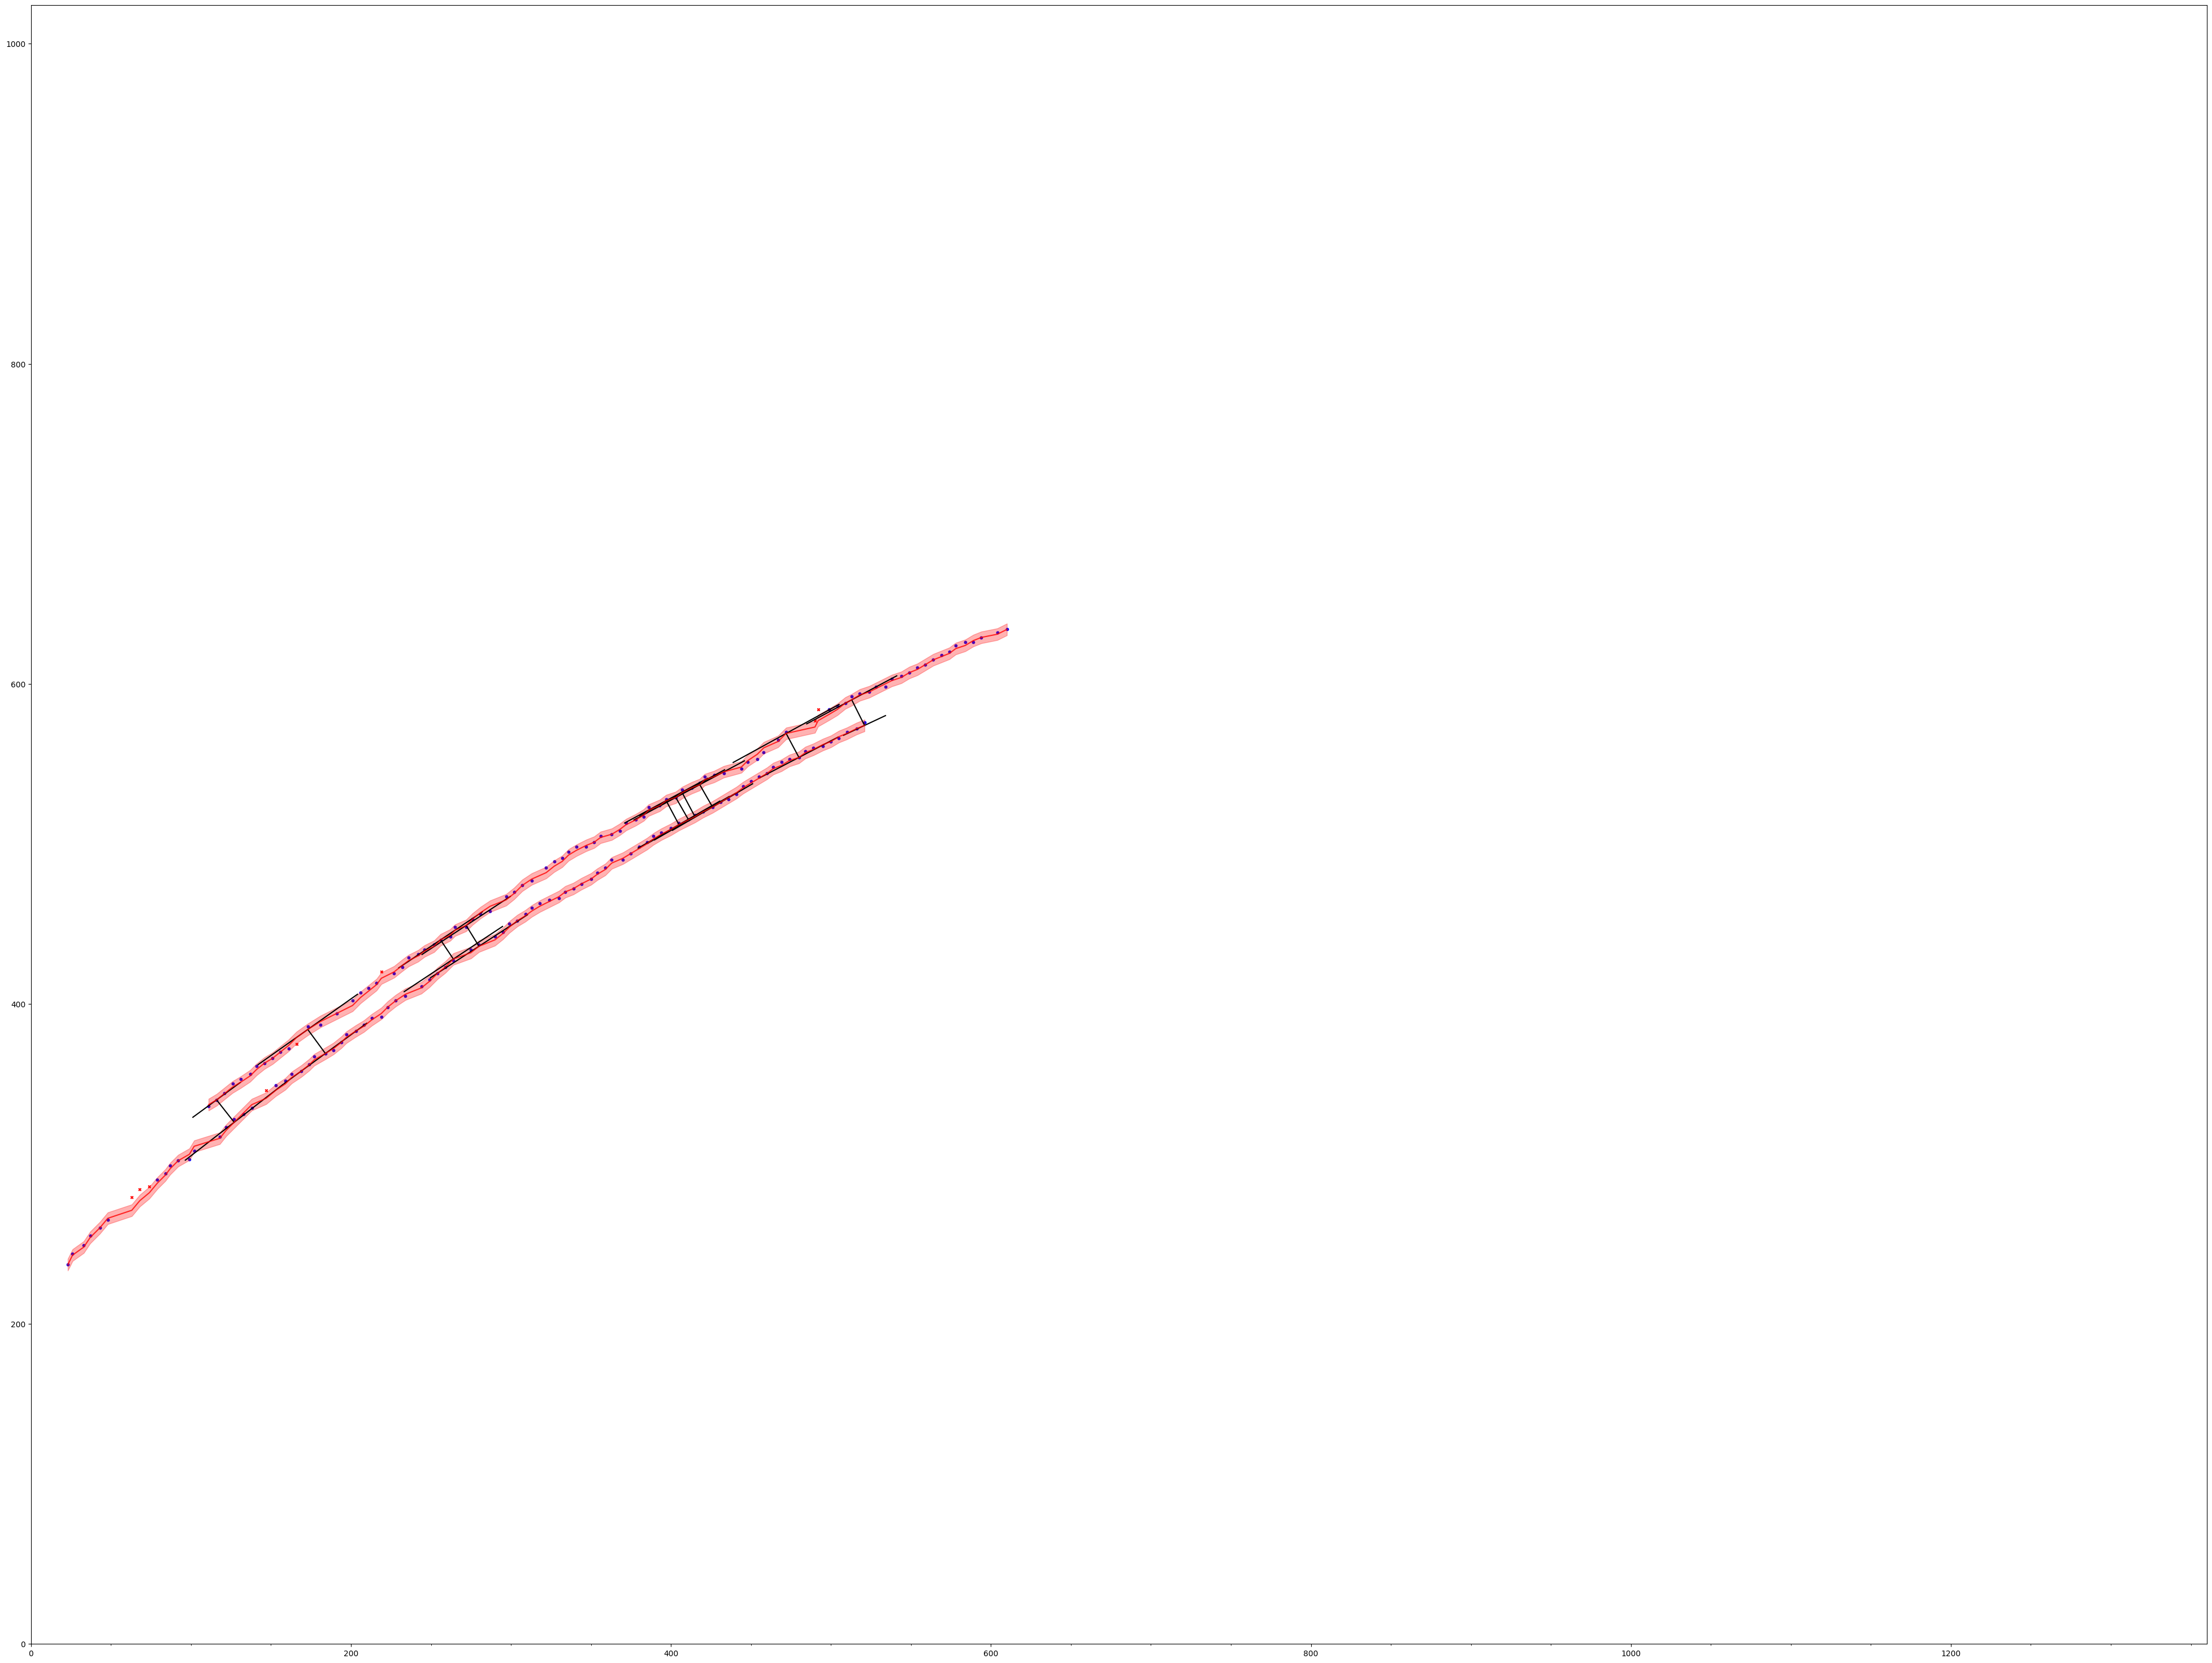

In [ ]:
def theta(v1, v2, for_measure=False):
    dot = np.dot(v1, v2)
    length1 = np.linalg.norm(v1)
    length2 = np.linalg.norm(v2)
    # Compute the angle in radians
    angle = np.arccos(dot / (length1 * length2))
    # Convert to degrees
    angle_degrees = np.degrees(angle)

    if for_measure:
        if angle_degrees >= 90:
            angle_degrees = 180 - angle_degrees
    
    try:
        return angle_degrees[0]
    except:
        return angle_degrees

def tangent_ensemble(base_ind, repeat, p_left, p_right):
    ind_list = np.zeros((repeat*2+1, 2))
    for i in range(-repeat, repeat+1):
        ind_list[i+repeat] = np.array([base_ind+i-p_left, base_ind+i+p_right])
    return ind_list.astype(np.int32)

b = disloc_info['b'].copy()

#* Lower
chosen_intensity_coord_lower = np.array(disloc_info['lower']['chosen_intensity_coord']).copy()
smoothed_data_lower = disloc_info['lower']['smoothed_data'].copy()
effect_ind_lower = disloc_info['lower']['effect_ind'].copy()
abnormal_ind_lower = disloc_info['lower']['abnormal_ind'].copy()
bound_lower = disloc_info['lower']['bound'].copy()
low_lower, up_lower = bound_lower[:,0], bound_lower[:,1]

#* Extract effect coordinates
x_coord_lower = chosen_intensity_coord_lower[:,1]
smoothed_coord_lower = np.concatenate([
    x_coord_lower.reshape(-1,1),
    smoothed_data_lower.reshape(-1,1),
], axis=1) #* Return the smoothed coordinates.

chosen_intensity_coord_lower[:, [0, 1]] = chosen_intensity_coord_lower[:, [1, 0]]
chosen_intensity_coord_lower_effect = chosen_intensity_coord_lower[effect_ind_lower]

#TODO update 230928: the `chosen_intensity_coord_lower_effect` is the coordinates of smoothed data.
chosen_intensity_coord_lower_effect = np.array([
    smoothed_coord_lower[np.argmin(
        np.linalg.norm(chosen_intensity_coord_lower_effect[i]-smoothed_coord_lower, axis=1))]
        for i in range(len(chosen_intensity_coord_lower_effect))])

#* Upper
chosen_intensity_coord_upper = np.array(disloc_info['upper']['chosen_intensity_coord']).copy()
smoothed_data_upper = disloc_info['upper']['smoothed_data'].copy()
effect_ind_upper = disloc_info['upper']['effect_ind'].copy()
abnormal_ind_upper = disloc_info['upper']['abnormal_ind'].copy()
bound_upper = disloc_info['upper']['bound'].copy()
low_upper, up_upper = bound_upper[:,0], bound_upper[:,1]

#* Extract effect coordinates
x_coord_upper = chosen_intensity_coord_upper[:,1]
smoothed_coord_upper = np.concatenate([
    x_coord_upper.reshape(-1,1),
    smoothed_data_upper.reshape(-1,1),
], axis=1) #* Return the smoothed coordinates.

chosen_intensity_coord_upper[:, [0, 1]] = chosen_intensity_coord_upper[:, [1, 0]]
chosen_intensity_coord_upper_effect = chosen_intensity_coord_upper[effect_ind_upper]

#TODO update 230928: the `chosen_intensity_coord_lower_effect` is the coordinates of smoothed data.
chosen_intensity_coord_upper_effect = np.array([
    smoothed_coord_upper[np.argmin(
        np.linalg.norm(chosen_intensity_coord_upper_effect[i]-smoothed_coord_upper, axis=1))]
        for i in range(len(chosen_intensity_coord_upper_effect))])

#* Main
fig, ax = plt.subplots(figsize=(50, 50*image.shape[0]/image.shape[1]))
repeat_time, l1_left, l1_right = 5, 5, 5 #* Tangent vector part
# l2_search_num = 10 #* Return m points in l2 based on NN search
distance_info = []
count_debug = 0

#! Calculate tangent vector of upper dislocation
upper_vector_buffer = []
for i in range(chosen_intensity_coord_upper_effect.shape[0]):
    p_base = np.array(chosen_intensity_coord_upper_effect[i])
    ind_p_l1 = np.argmin(np.linalg.norm(p_base - smoothed_coord_upper, axis=1))
    ensemble_ind = np.unique(np.clip(
        tangent_ensemble(ind_p_l1, repeat_time, l1_left, l1_right), 0, len(smoothed_coord_upper)-1), axis=0)
    
    l1_mat = []
    for l1_vector_ind in ensemble_ind:
        l1_a1 = smoothed_coord_upper[l1_vector_ind[0]]
        l1_a2 = smoothed_coord_upper[l1_vector_ind[1]]
        l1_vector = l1_a2 - l1_a1
        l1_mat.append(l1_vector)
    
    tangent_vector = np.mean(np.array(l1_mat), axis=0)
    upper_vector_buffer.append([p_base, tangent_vector])

upper_vector_buffer = np.array(upper_vector_buffer)

lower_vector_buffer = []
for i in range(chosen_intensity_coord_lower_effect.shape[0]):
    p_base = np.array(chosen_intensity_coord_lower_effect[i])
    ind_p_l1 = np.argmin(np.linalg.norm(p_base - smoothed_coord_lower, axis=1))
    ensemble_ind = np.unique(np.clip(
        tangent_ensemble(ind_p_l1, repeat_time, l1_left, l1_right), 0, len(smoothed_coord_lower)-1), axis=0)
    
    l1_mat = []
    for l1_vector_ind in ensemble_ind:
        l1_a1 = smoothed_coord_lower[l1_vector_ind[0]]
        l1_a2 = smoothed_coord_lower[l1_vector_ind[1]]
        l1_vector = l1_a2 - l1_a1
        l1_mat.append(l1_vector)
    
    tangent_vector = np.mean(np.array(l1_mat), axis=0)
    lower_vector_buffer.append([p_base, tangent_vector])

lower_vector_buffer = np.array(lower_vector_buffer)
    
    
for i in range(lower_vector_buffer.shape[0]):
    p_base = np.array(lower_vector_buffer[i][0])
    tangent_vector = np.array(lower_vector_buffer[i][1])
    
    theta_list = []
    #* Fill in the angle values
    for j in range(upper_vector_buffer.shape[0]):
        l2_v_ = upper_vector_buffer[j]
        p_upper = l2_v_[0]
        tangent_upper = l2_v_[1]
        p_res = p_upper - p_base
        theta_ = np.abs([theta(p_res, tangent_upper)-90, theta(p_res, tangent_vector)-90])
        theta_list.append(np.max(theta_))

    # res_norm_l = np.linalg.norm(p_base - smoothed_coord_upper, axis=1)
    theta_list = np.array(theta_list)
    
    # ind_p = np.argpartition(theta_list, 5)[:5]
    lowest_angle = theta_list[np.argmin(theta_list)]
    coord_p = upper_vector_buffer[np.argmin(theta_list)][0]
    tangent_p = upper_vector_buffer[np.argmin(theta_list)][1]

    if lowest_angle < 2: #! angle of tolerance
        # if count_debug == 1:
        #     print(theta_list, ind_p, coord_p, lowest_p_l2)
        # count_debug += 1

        plt.plot([p_base[0], coord_p[0]], [p_base[1], coord_p[1]], 'k')

        plt.plot([p_base[0]-tangent_vector[0]/2, p_base[0]+tangent_vector[0]/2], 
            [p_base[1]-tangent_vector[1]/2, p_base[1]+tangent_vector[1]/2], 'k')
        plt.plot([coord_p[0]-tangent_p[0]/2, coord_p[0]+tangent_p[0]/2], 
            [coord_p[1]-tangent_p[1]/2, coord_p[1]+tangent_p[1]/2], 'k')
        vector_ = coord_p - p_base
        vector_orthogonal = np.array([-vector_[1], vector_[0]])
        angle = theta(b, vector_orthogonal, for_measure=True)
        
        #TODO if image rotated and burgers vector rotated: off
        #TODO if image rotated and burgers vector not rotated: on
        #TODO if image not rotated and burgers vector rotated: on
        #TODO if image not rotated and burgers vector not rotated: off
        # image_rotated = True
        # if image_rotated:
        #     angle = 90 - angle
        
        distance_info.append([p_base, coord_p, angle])

distance_info = np.array(distance_info, dtype=object)
draw_dislocplot()
plt.xlim(0, image.shape[1]) 
plt.ylim(0, image.shape[0])

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

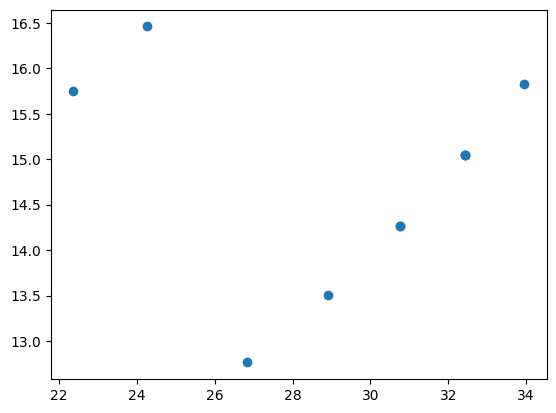

In [55]:
distance_true = []
for i in distance_info:
    p1, p2 = i[0], i[1]
    angle = i[-1]
    d_true = np.linalg.norm(p1-p2)/pix_per_nm
    distance_true.append([d_true, angle])
    
plt.scatter(np.array(distance_true)[:,1], np.array(distance_true)[:,0])

Save the distance information.

In [62]:
pth_sav = pth_out
np.save(os.path.join(pth_sav, 'distance_info_1.npy'), distance_info)

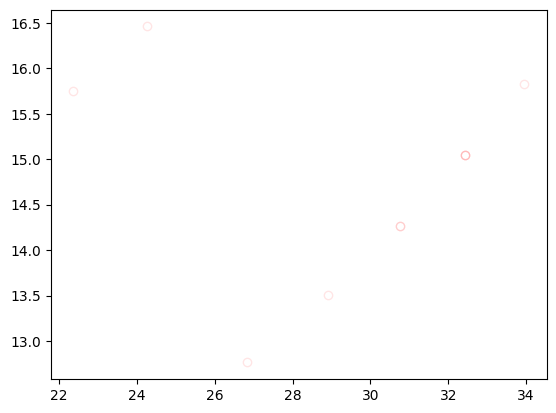

In [79]:
pth_sav = f'./demo/'
info_buffer = np.arange(1,2)

pix_buffer = [1]

distance_info = []
count_200 = 0
for i in info_buffer:
    distance_info_ = np.load(os.path.join(pth_sav, f'distance_info_{i}.npy'), allow_pickle=True).tolist()
    distance_info += distance_info_
    if i in pix_buffer:
        count_200 += len(distance_info_)
        
count_embed = np.array([count_200])

#TODO define gauge - pix relationship
points = np.load(os.path.join(pth_sav, 'gauge_info.npy'))
pix_per_nm_50 = abs(points[0][0]-points[1][0])/200

dict_gauge = {0: pix_per_nm_50}

distance_true = []
for count_, i in enumerate(distance_info):
    count_category = np.where(count_ - count_embed < 0)[0][0]
    p1, p2 = i[0], i[1]
    angle = i[-1]
    d_true = np.linalg.norm(p1-p2)/dict_gauge[count_category]
    distance_true.append([d_true, angle])

#* Convert to csv
df = pd.DataFrame(distance_true, columns=['width (nm)', r'angle ($\theta$)',])
df.to_csv(os.path.join(pth_sav, f'angle_distance.csv'), index=False)

plt.scatter(np.array(distance_true)[:,1], np.array(distance_true)[:,0],
            c='w', marker='o', edgecolors='r',alpha=0.1)
    
plt.title(f'', fontsize = 80, c = 'k')

plt.show()

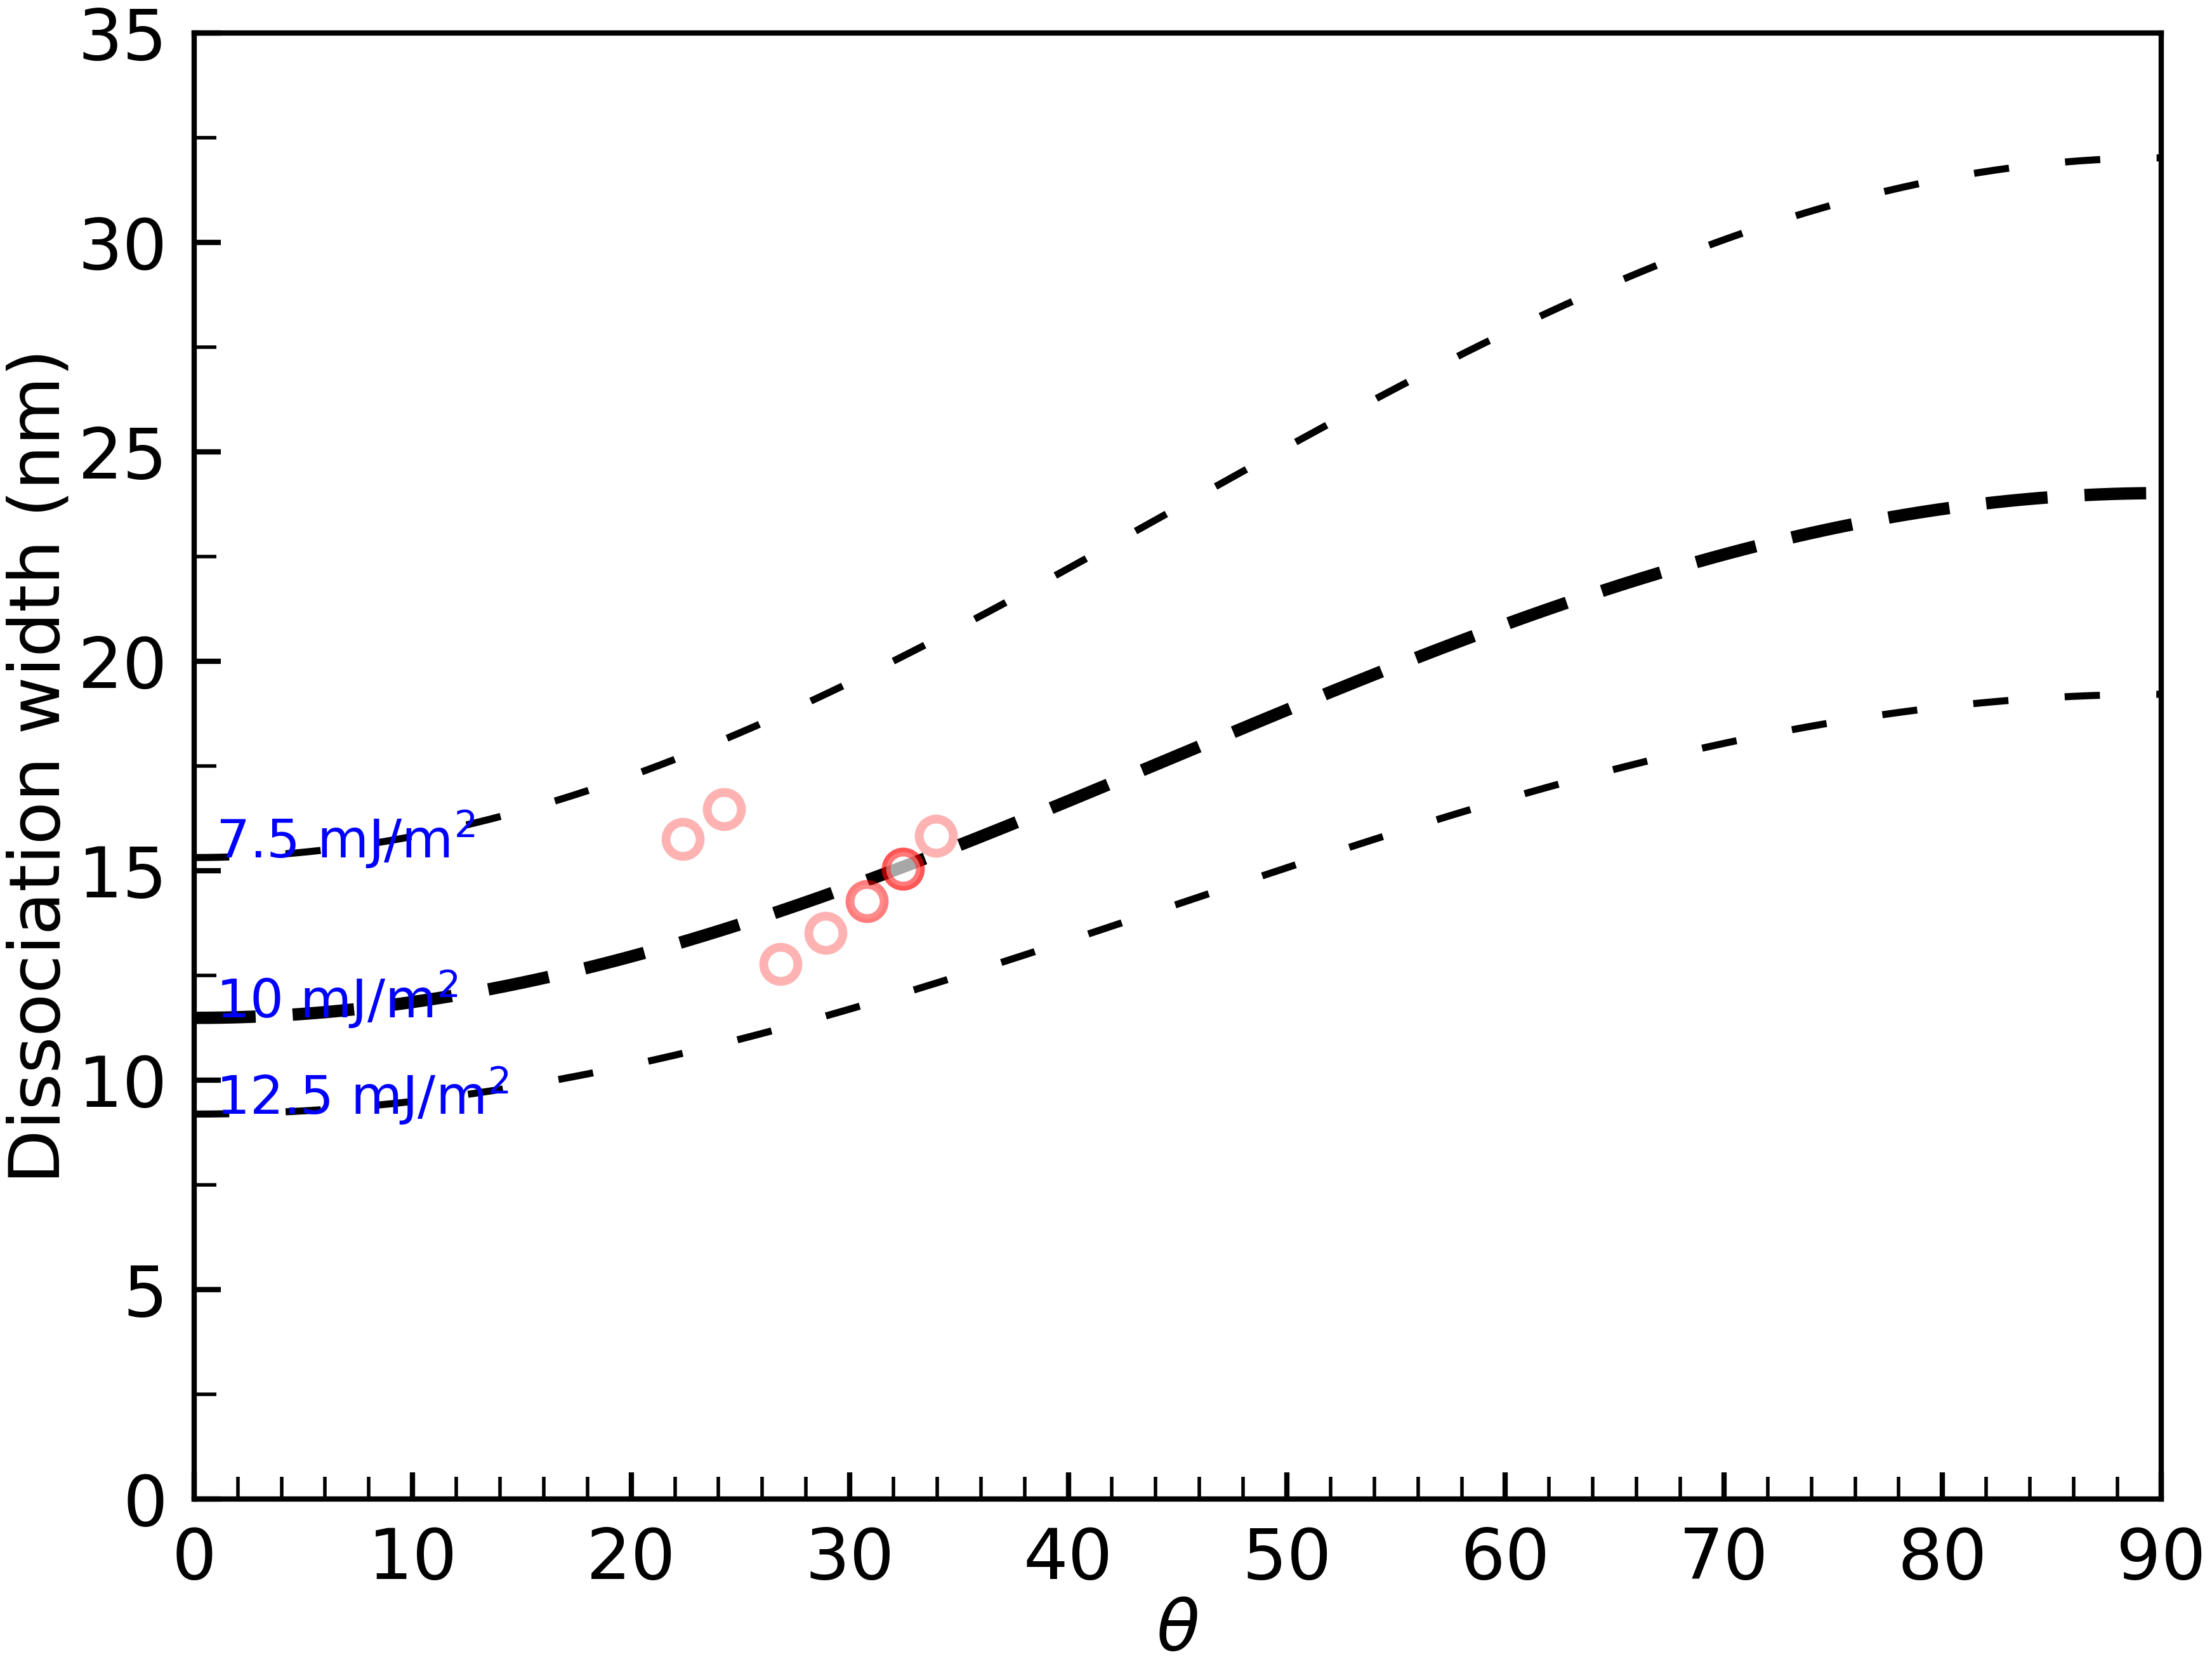

In [ ]:
class MyLocator(matplotlib.ticker.AutoMinorLocator):
    def __init__(self, n=2):
        super().__init__(n=n)
matplotlib.ticker.AutoMinorLocator = MyLocator

new_ticksy = np.linspace(0, 40, 9)
new_ticksx = np.linspace(0, 90, 10)
figsize = 40, 30
figure, ax = plt.subplots(figsize = figsize)

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

plt.tick_params(labelsize=23, which = 'major', length = 30, width = 6, direction='in', color = 'k')
plt.tick_params(which = 'minor', length = 25, width = 4, direction='in', color = 'k')

plt.rcParams["xtick.minor.visible"] = False
plt.rcParams["ytick.minor.visible"] = False

labels = ax.get_xticklabels() + ax.get_yticklabels()
plt.ylabel(r'Dissociation width (nm)', fontsize = 80, c = 'k')
plt.xlabel(r'$\theta$', fontsize = 80, c = 'k')
plt.xticks(new_ticksx, c = 'k', fontsize = 80)
plt.yticks(new_ticksy, c = 'k', fontsize = 80)
plt.axis([0, 90, 0, 35])
ax.tick_params(pad = 30)
bwith = 6
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)

#*================================================

theta_p, width_p = np.array(distance_true)[:,1], np.array(distance_true)[:,0]

def d_w_fit(theta_x, aa):
    return expo*gh*expo*(np.power(b/expo, 2))*(2 - v)*(1 - 2*v*np.cos(np.radians(2*theta_x))/(2-v))/(8*math.pi*aa*(1-v)/1000)

#* parameters from experimental data
expo = 10**9
gh = 87 #* shear modulus, GPa
v = 0.3 #* Poisson's ratio
aa1 = 7.5 #* Low bound for sfe, mJ/m^2
aa2 = 10
aa3 = 12.5 #* upper bound
b = 0.145295567 #* Burgers vector
theta_x = np.linspace(0, 90, 10000)
width_x1 = d_w_fit(theta_x, aa1)
width_x2 = d_w_fit(theta_x, aa2)
width_x3 = d_w_fit(theta_x, aa3)

plt.plot(theta_x, width_x1, color = 'k', linewidth = 8, zorder = 0, linestyle = (0, (5, 8)))
plt.text(1, width_x1[0], rf'{aa1} mJ/m$^2$', fontsize = 60, c = 'blue')
plt.plot(theta_x, width_x2, color = 'k', linewidth = 14, zorder = 0, linestyle = (0, (5, 3)))
plt.text(1, width_x2[0], rf'{aa2} mJ/m$^2$', fontsize = 60, c = 'blue')
plt.plot(theta_x, width_x3, color = 'k', linewidth = 8, zorder = 0, linestyle = (0, (5, 8)))
plt.text(1, width_x3[0], rf'{aa3} mJ/m$^2$', fontsize = 60, c = 'blue')

width_x3_p = d_w_fit(theta_p, aa3)
res = width_x3_p - width_p
width_p = np.delete(width_p, np.where(res>1))
theta_p = np.delete(theta_p, np.where(res>1))

width_x1_p = d_w_fit(theta_p, aa1)
res = width_x1_p - width_p
width_p = np.delete(width_p, np.where(res<1))
theta_p = np.delete(theta_p, np.where(res<1))

plt.scatter(theta_p, width_p, color = 'w', s = 1500, marker = 'o', edgecolor = '#FF0000', linewidth = 10,
           label = 'CrCoNi RT deformed$',
           zorder = 1, alpha=0.3)

plt.title(f'', fontsize = 80, c = 'k')
# plt.legend()
plt.show()